In [14]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm

resol = 200
pi = np.pi
version_table()

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> Parameters </h1>

In [15]:
#space discretization
L = 4*pi
N = 32 #number of sites on the lattice
delta_L = L/N
position_lattice_list = np.linspace(-L/2, L/2, N)

#photon field
n_modes = 32 #UV cut-off
omega_tab = np.array([2*pi*n/L for n in range(n_modes)]) #tab of frequencies (with engough points to get omega_0)
k_tab = np.copy(omega_tab)

#Jaynes-Cummings parameter g_0 and number of atoms
g_0 = 1.2*1j
n_A = 5

#fix the energies and the initial wave packet
omega_0 = 1.8
omega_A = 1
bandwith = 2*pi*np.abs(g_0)**2*omega_A
sigma = L/16

print("Bandwith: ", bandwith)
print("Delta Omega ~ ", 1/sigma)

#tab with the coupling parameters
use_WW_approx = False
g_tab = np.zeros((n_modes, n_A), dtype=complex)
for i in range(n_modes):
    for j in range(n_A):
        if use_WW_approx:
            g_tab[i, j] = g_0*np.sqrt(omega_A)
        else:
            g_tab[i, j] = g_0*np.sqrt(omega_tab[i]) #in my case, g is independant of the atom index


#dimension of the subspace restricted to 2 photons
dim_subspace = n_modes * (2*n_modes + 1) + 2*n_modes*n_A + n_A*(n_A-1)//2
print("Max momentum: ", k_tab[-1])
print("Dimension of the subspace: ", dim_subspace)

Bandwith:  9.047786842338605
Delta Omega ~  1.2732395447351628
Max momentum:  15.5
Dimension of the subspace:  2410


<h1> Visualize initial wave packet </h1>

r_bar: -3.141592653589793
k_bar: 2.0


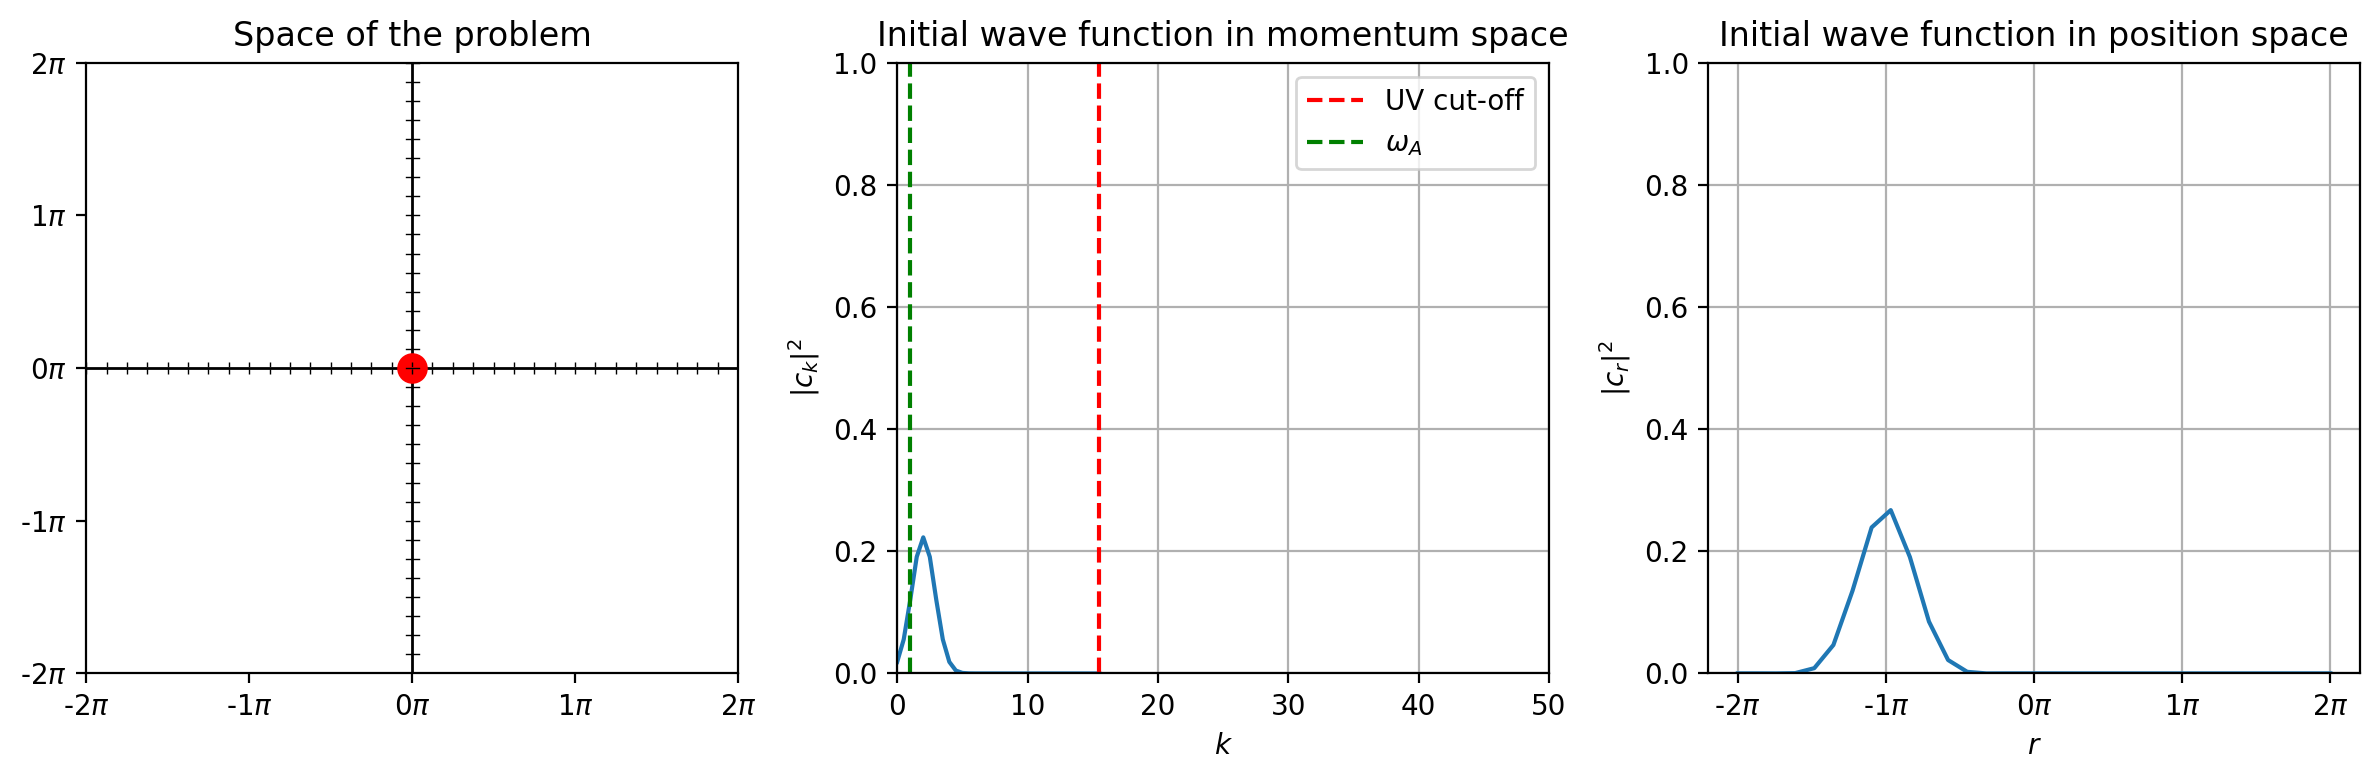

In [16]:
#pick up the positive value for k_bar so that the mean frequency is the closest from omega_0
k_bar = k_tab[np.argmin(np.abs(k_tab - omega_0))]

#init position for horizontal direction, pick up the closest value of x0 in position tab
r_bar = -L/4
coef_momentum = np.zeros(n_modes, dtype=complex)
coef_position = np.zeros(N, dtype=complex)

for i in range(n_modes):
    coef_momentum[i] = np.exp(-0.5*sigma**2*(k_tab[i] - k_bar)**2 -1j * k_tab[i] * r_bar)
    
normalize_factor = np.sqrt(np.conjugate(coef_momentum)@coef_momentum)
coef_momentum = coef_momentum/normalize_factor #normalize the wave packet

#Fourier transform to get the coefficients in position space
for i in range(N):
    for j in range(n_modes):
        coef_position[i] += 1/np.sqrt(N) * coef_momentum[j]*np.exp(1j*k_tab[j]*position_lattice_list[i])
normalize_factor = np.sqrt(np.conjugate(coef_position)@coef_position)
coef_position = coef_position/normalize_factor #normalize the wave packet


print("r_bar:", r_bar)
print("k_bar:", k_bar)

fig, ax = plt.subplots(1, 3, figsize=(12,4), dpi=resol)

#plot the horizontal direction
ax[0].hlines(0, -L/2, L/2, color='black', linewidth=1)
#plot the vertical direction
ax[0].vlines(0, -L/2, L/2, color='black', linewidth=1)
ax[0].set_xlim(-L/2, L/2)
ax[0].set_ylim(-L/2, L/2)

#plot the atom
ax[0].plot(0, 0, marker='o', markersize=10, color='red')

#put appropriate ticks in pi units
ax[0].set_xticks([i*pi for i in range(-1*int(L//(2*pi)), int(L//(2*pi)+1))])
ax[0].set_xticklabels([str(i)+'$\\pi$' for i in range(-1*int(L//(2*pi)),int(L//(2*pi)+1))])
ax[0].set_yticks([i*pi for i in range(-1*int(L//(2*pi)), int(L//(2*pi)+1))])
ax[0].set_yticklabels([str(i)+'$\\pi$' for i in range(-1*int(L//(2*pi)),int(L//(2*pi)+1))])

#show the grid of discretization
for i in range(-N//2, N//2+1):
    ax[0].axhline(i*delta_L, 0.49, 0.51, color='black', lw=0.5)
    ax[0].axvline(i*delta_L, 0.49, 0.51, color='black', linestyle='--', lw=0.5)
ax[0].set_title("Space of the problem")


#initial wave function in momentum space
ax[1].plot(k_tab, np.abs(coef_momentum)**2)
ax[1].set_xlabel('$k$')
ax[1].set_ylabel('$|c_k|^2$')
ax[1].set_xlim(0, 50)
ax[1].vlines(np.max(k_tab), 0, 1, color='red', linestyle='--', label='UV cut-off')
ax[1].vlines(omega_A, 0, 1, color='green', linestyle='--', label='$\\omega_A$')
ax[1].grid()
ax[1].set_ylim(0, 1)    
ax[1].set_title("Initial wave function in momentum space")
ax[1].legend()

#initial wave function in position space
ax[2].plot(position_lattice_list, np.abs(coef_position)**2, label='position space')
ax[2].set_xlabel('$r$')
ax[2].set_ylabel('$|c_r|^2$')
#set proper labels for ticks
ax[2].set_xticks([i*pi for i in range(-1*int(L//(2*pi)), int(L//(2*pi)+1))])
ax[2].set_xticklabels([str(i)+'$\\pi$' for i in range(-1*int(L//(2*pi)),int(L//(2*pi)+1))])
ax[2].grid()
ax[2].set_ylim(0, 1)
ax[2].set_title("Initial wave function in position space")

plt.tight_layout()
plt.show()

<h1> Hamiltonian generation </h1>

Recall that I work with the basis:
$$ \left\{ \ket{2_a, 0_b, 0}, \ket{0_a, 2_b, 0}, \ket{1_a, 1_b, 0}, \ket{1_a, 0, 1}, \ket{0, 1_b, 1}, \ket{0_a, 0_b, 2}\right \}$$

In [89]:
dim_subspace = n_modes * (2*n_modes + 1) + 2*n_modes*n_A + n_A*(n_A-1)//2
print("Dimension of the Hilbert space:", dim_subspace)

def generate_hamilt(jc_coupling=True):

    H_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)
        
    index = 0 #dummy way to do it but I'm struggling to find a direct mapping

    ###Diagonal elements

    #diagonal elements with two photons in the horizontal direction
    for i in range(n_modes):
        for j in range(i, n_modes):
            H_matrix[index, index] = omega_tab[i] + omega_tab[j]
            index += 1

    #diagonal elements with two photons in the vertical direction
    for i in range(n_modes):
        for j in range(i, n_modes):
            H_matrix[index, index] = omega_tab[i] + omega_tab[j]
            index += 1
            
    #diagonal elements with two photons in distinct directions
    for i in range(n_modes**2):
        H_matrix[index,index] = omega_tab[int(i//n_modes)] + omega_tab[int(i%n_modes)]
        index += 1

    #diagonal elements with one horizontal photon and one excited atom
    for i in range(n_modes):
        for j in range(n_A):
            H_matrix[index,index] = omega_tab[i] + omega_A
            index += 1

    #diagonal elements with one vertical photon and the atom
    for i in range(n_modes):
        for j in range(n_A):
            H_matrix[index,index] = omega_tab[i] + omega_A
            index += 1

    #diagonal elements with two excited atoms
    if n_A > 1:
        for i in range(n_A):
            for j in range(i+1, n_A):
                H_matrix[index,index] = 2*omega_A
                index += 1

    ## Off diagonal elements

    if jc_coupling:

        #|2,0,0> <-> |1,0,1>
        dummy_index_0 = 0
        for i in range(n_modes):
            for j in range(i, n_modes):
                dummy_index_1 = n_modes*(2*n_modes + 1)
                for k in range(n_modes):
                    for l in range(n_A):
                        if k == i:
                            if i == j:
                                H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(np.conjugate(g_tab[j,l]))
                                H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                            else:
                                H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[j,l])
                                H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                        if k == j:
                            if i == j:
                                H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[i,l])
                                H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                            else:
                                H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[i,l])
                                H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                        dummy_index_1 += 1
                dummy_index_0 += 1

        #|0,2,0> <-> |0,1,1>
        dummy_index_0 = n_modes*(n_modes + 1)//2
        for i in range(n_modes):
            for j in range(i, n_modes):
                dummy_index_1 = n_modes*(2*n_modes + 1) + n_modes*n_A
                for k in range(n_modes):
                    for l in range(n_A):
                        if k == i:
                            if i == j:
                                H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[j,l])
                                H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                            else:
                                H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[j,l])
                                H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                        if k == j:
                            if i == j:
                                H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[i,l])
                                H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                            else:
                                H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[i,l])
                                H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                        dummy_index_1 += 1
                dummy_index_0 += 1

        #|1,1,0> <-> |1,0,1>
        dummy_index_0 = n_modes*(n_modes + 1)
        for i in range(n_modes):
            for j in range(n_modes):
                    dummy_index_1 = n_modes*(2*n_modes + 1) 
                    for k in range(n_modes):
                        for l in range(n_A):
                            if k == i:
                                H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[j,l])
                                H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                            if k == j:
                                H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[i,l])
                                H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                            
                            dummy_index_1 += 1
                    dummy_index_0 += 1
        
        #|1,1,0> <-> |0,1,1>
        dummy_index_0 = n_modes*(n_modes + 1)
        for i in range(n_modes):
            for j in range(n_modes):
                    dummy_index_1 = n_modes*(2*n_modes + 1) + n_modes*n_A
                    for k in range(n_modes):
                        for l in range(n_A):
                            if k == i:
                                H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[j,l])
                                H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                            if k == j:
                                H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[i,l])
                                H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                            
                            dummy_index_1 += 1
                    dummy_index_0 += 1


        if n_A > 1:
            #|1,0,1> <-> |0,0,2>
            dummy_index_0 = n_modes*(2*n_modes + 1)
            for i in range(n_modes):
                for j in range(n_A):
                    dummy_index_1 = n_modes*(2*n_modes + 1) + 2*n_modes*n_A
                    for k in range(n_A):
                        for l in range(k+1, n_A):
                            if k == j:
                                H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[i,l])
                                H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                            if l == j:
                                H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[i,k])
                                H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                            dummy_index_1 += 1
                    dummy_index_0 += 1
                
            #|0,1,1> <-> |0,0,2>
            dummy_index_0 = n_modes*(2*n_modes + 1) + n_modes*n_A
            for i in range(n_modes):
                for j in range(n_A):
                    dummy_index_1 = n_modes*(2*n_modes + 1) + 2*n_modes*n_A
                    for k in range(n_A):
                        for l in range(k+1, n_A):
                            if k == j:
                                H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[i,k])
                                H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                            if l == j:
                                H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[i,l])
                                H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                            dummy_index_1 += 1
                    dummy_index_0 += 1


    H = qt.Qobj(H_matrix)
    print("Hermicity check:", H.isherm)
    #print("check value of omega_A:", omega_A)

    return H

Dimension of the Hilbert space: 3650


<h1> Occupation operators </h1>


I define the operators $N_a(k) = a_k^{\dagger} a_k$, $N_b(k) = b_k^{\dagger} b_k$ and $N_j = (1+\sigma_j^z)/2$.


In [90]:
occupation_a_list = []
occupation_b_list = []
sigma_z_list = []

#for horizontal modes
for n in range(n_modes):
    occupation_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)
    #|2,0,0> states
    dummy_index = 0
    for i in range(n_modes):
        for j in range(i, n_modes):
            if i == n or j == n:
                if i == j:
                    occupation_matrix[dummy_index, dummy_index] = 2
                else:
                    occupation_matrix[dummy_index, dummy_index] = 1
            dummy_index += 1
    
    #|1,1,0> states
    dummy_index = n_modes*(n_modes + 1)
    for i in range(n_modes):
        for j in range(n_modes):
            if i == n:
                occupation_matrix[dummy_index, dummy_index] = 1
            dummy_index += 1
            

    #|1,0,1> states
    dummy_index = n_modes*(2*n_modes + 1)
    for i in range(n_modes):
        for j in range(n_A):
            if i == n:
                occupation_matrix[dummy_index, dummy_index] = 1
            dummy_index += 1
    
    occupation_operator = qt.Qobj(occupation_matrix)
    occupation_a_list.append(occupation_operator)

#same for vertical modes
for n in range(n_modes):
    occupation_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)
    #|0,2,0> states
    dummy_index = n_modes*(n_modes + 1)//2
    for i in range(n_modes):
        for j in range(i, n_modes):
            if i == n or j == n:
                if i == j:
                    occupation_matrix[dummy_index, dummy_index] = 2
                else:
                    occupation_matrix[dummy_index, dummy_index] = 1
            dummy_index += 1
    
    #|1,1,0> states
    dummy_index = n_modes*(n_modes + 1)
    for i in range(n_modes):
        for j in range(n_modes):
            if j == n:
                occupation_matrix[dummy_index, dummy_index] = 1
            dummy_index += 1
            

    #|0,1,1> states
    dummy_index = n_modes*(2*n_modes + 1) + n_modes*n_A
    for i in range(n_modes):
        for j in range(n_A):
            if i == n:
                occupation_matrix[dummy_index, dummy_index] = 1
            dummy_index += 1
    
    occupation_operator = qt.Qobj(occupation_matrix)
    occupation_b_list.append(occupation_operator)

#for sigma_z
for x in range(n_A):
    sigma_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)
    #|1,0,1> states 
    dummy_index = n_modes*(2*n_modes + 1)
    for i in range(n_modes):
        for j in range(n_A):
            if j == x:
                sigma_matrix[dummy_index, dummy_index] = 1
            dummy_index += 1
    
    #|0,1,1> states
    dummy_index = n_modes*(2*n_modes + 1) + n_modes*n_A
    for i in range(n_modes):
        for j in range(n_A):
            if j == x:
                sigma_matrix[dummy_index, dummy_index] = 1
            dummy_index += 1
    
    #|0,0,2> states
    dummy_index = n_modes*(2*n_modes + 1) + 2*n_modes*n_A
    for i in range(n_A):
        for j in range(i+1, n_A):
            if i == x or j == x:
                sigma_matrix[dummy_index, dummy_index] = 1
            dummy_index += 1

    sigma_operator = qt.Qobj(sigma_matrix)
    sigma_z_list.append(sigma_operator)


Finally, I define the operators:

$$N_a = \sum_k N_a(k) \,\, , \,\, N_b = \sum_k N_b(k)  \, \, , \, \, N _A= \sum_j N_j$$

In [91]:
N_a = 0
N_b = 0
N_atom = 0
for i in range(n_modes):
    N_a += occupation_a_list[i]
    N_b += occupation_b_list[i]

for i in range(n_A):
    N_atom += sigma_z_list[i]

<h1> Time evolution </h1>

Let me define: 

$$C(t) = \bra{\psi(t)} N_a N_b \ket{\psi(t)} $$

I look at the evolution of $C(t)$ against time. I initialize the system in the state:

$$ \ket{\psi_0} = \left(\sum_k c_k \ket{1_k}\right) \otimes \left(\sum_{k'} c_{k'}\ket{1_{k'}}\right) $$

Which gives, in our basis:

$$ \ket{\psi_0} = \sum_{k_a, k_b} c_{k,a} c_{k,b} \ket{1_{k, a}; 1_{k,b}; 0} $$

The coefficientsd $c_k$ are chosen so that both photons are initially indistinguishable Gaussia wave packets. They are given by, up to a constant, by:

$$c_k = \exp \left(—\frac{\sigma^2}{2}(k - \bar{k})^2 - i k \bar{r}\right) $$

In [92]:
k_tab = np.copy(omega_tab)
k_bar = k_tab[np.argmin(np.abs(k_tab - omega_0))]
r_bar_a = -L/4
delta_r = 0
r_bar_b = r_bar_a + delta_r

c_list = []

init_state = 0
for i in range(n_modes**2):
    k_a = k_tab[int(i//n_modes)]
    k_b = k_tab[int(i%n_modes)]
        
    c_a = np.exp(-0.5*sigma**2*(k_a - k_bar)**2 -1j * k_a * r_bar_a)
    c_b = np.exp(-0.5*sigma**2*(k_b - k_bar)**2 -1j * k_b * r_bar_b)

    if i//n_modes == i/n_modes:
        c_list.append(c_a)

    init_state += c_a * c_b * qt.basis(dim_subspace, n_modes*(n_modes+1) + i)

init_state = init_state.unit()

Now evolve the system

In [93]:
dt = 0.5
T = L/2
times = np.linspace(0, T, int(T/dt))
C_operator = N_a*N_b
H = generate_hamilt(jc_coupling=True)
data = qt.sesolve(H, init_state, times, e_ops=[C_operator, N_atom], options={"progress_bar":True, "nsteps":10000})

Hermicity check: True
11.8%. Run time:   3.29s. Est. time left: 00:00:00:24
23.5%. Run time:   6.58s. Est. time left: 00:00:00:21
35.3%. Run time:   9.80s. Est. time left: 00:00:00:17
41.2%. Run time:  11.38s. Est. time left: 00:00:00:16
52.9%. Run time:  14.60s. Est. time left: 00:00:00:12
64.7%. Run time:  17.81s. Est. time left: 00:00:00:09
70.6%. Run time:  19.42s. Est. time left: 00:00:00:08
82.4%. Run time:  22.60s. Est. time left: 00:00:00:04
94.1%. Run time:  25.82s. Est. time left: 00:00:00:01
100.0%. Run time:  27.43s. Est. time left: 00:00:00:00
Total run time:  27.47s


Plot the results

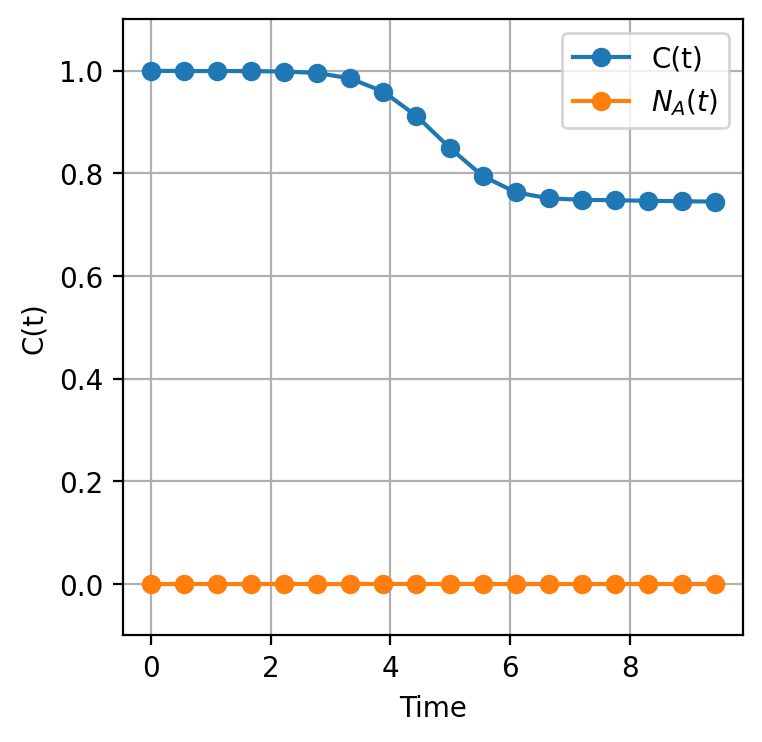

In [94]:
C_values = data.expect[0]
N_A_values = data.expect[1]
fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=resol)
ax.plot(times, C_values, marker='o', label='C(t)')
ax.plot(times, N_A_values, marker='o', label='$N_A(t)$')
ax.set_xlabel('Time')
ax.set_ylabel('C(t)')
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.grid()

plt.show()

<h1> Final coherence against detunning </h1>

Now if define :

$$ C = C(t\rightarrow \infty)$$
 
I want to check how it behaves against the detunning. I will define a big function that computes the coherence for given values of $\omega_0$ and $\omega_A$

In [18]:
def get_coherence(omega_0, omega_A, g_0, use_WW_approx=False):
    ##Parameters of the problem
    L = 4*pi
    n_modes = 32 #UV cut-off
    omega_tab = np.array([2*pi*n/L for n in range(n_modes)]) #tab of frequencies (with engough points to get omega_0)
    k_tab = np.copy(omega_tab)

    #Jaynes-Cummings parameter g_0 and number of atoms
    n_A = 1

    #fix the energies and the initial wave packet
    bandwith = 2*pi*np.abs(g_0)**2*omega_A
    sigma = L/16

    #tab with the coupling parameters
    g_tab = np.zeros((n_modes, n_A), dtype=complex)
    for i in range(n_modes):
        for j in range(n_A):
            if use_WW_approx:
                g_tab[i, j] = g_0*np.sqrt(omega_A)*1j
            else:
                g_tab[i, j] = g_0*np.sqrt(omega_tab[i])*1j #in my case, g is independant of the atom index
    
    #conduct some checks
    if omega_A > omega_tab[-1] or omega_A < omega_tab[0]:
        print("Warning: omega_A is out of the UV cut-off")
        return None
    
    if omega_0 < omega_tab[0] or omega_0 > omega_tab[-1]:
        print("Warning: omega_0 is out of the UV cut-off")
        return None

    if 1/sigma > 0.1*bandwith:
        print("Warning : the wave packet breaks the monocromatic limit")
        return None


    #dimension of the subspace restricted to 2 photons
    dim_subspace = n_modes * (2*n_modes + 1) + 2*n_modes*n_A + n_A*(n_A-1)//2

    #now define the Hamiltonian
    H_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)
    index = 0 #dummy way to do it but I'm struggling to find a direct mapping

    ###Diagonal elements

    #diagonal elements with two photons in the horizontal direction
    for i in range(n_modes):
        for j in range(i, n_modes):
            H_matrix[index, index] = omega_tab[i] + omega_tab[j]
            index += 1

    #diagonal elements with two photons in the vertical direction
    for i in range(n_modes):
        for j in range(i, n_modes):
            H_matrix[index, index] = omega_tab[i] + omega_tab[j]
            index += 1
            
    #diagonal elements with two photons in distinct directions
    for i in range(n_modes**2):
        H_matrix[index,index] = omega_tab[int(i//n_modes)] + omega_tab[int(i%n_modes)]
        index += 1

    #diagonal elements with one horizontal photon and one excited atom
    for i in range(n_modes):
        for j in range(n_A):
            H_matrix[index,index] = omega_tab[i] + omega_A
            index += 1

    #diagonal elements with one vertical photon and the atom
    for i in range(n_modes):
        for j in range(n_A):
            H_matrix[index,index] = omega_tab[i] + omega_A
            index += 1

    #diagonal elements with two excited atoms
    if n_A > 1:
        for i in range(n_A):
            for j in range(i+1, n_A):
                H_matrix[index,index] = 2*omega_A
                index += 1

    ## Off diagonal elements

    #|2,0,0> <-> |1,0,1>
    dummy_index_0 = 0
    for i in range(n_modes):
        for j in range(i, n_modes):
            dummy_index_1 = n_modes*(2*n_modes + 1)
            for k in range(n_modes):
                for l in range(n_A):
                    if k == i:
                        if i == j:
                            H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(np.conjugate(g_tab[j,l]))
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                        else:
                            H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[j,l])
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                    if k == j:
                        if i == j:
                            H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[i,l])
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                        else:
                            H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[i,l])
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])

                    dummy_index_1 += 1
            dummy_index_0 += 1

    #|0,2,0> <-> |0,1,1>
    dummy_index_0 = n_modes*(n_modes + 1)//2
    for i in range(n_modes):
        for j in range(i, n_modes):
            dummy_index_1 = n_modes*(2*n_modes + 1) + n_modes*n_A
            for k in range(n_modes):
                for l in range(n_A):
                    if k == i:
                        if i == j:
                            H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[j,l])
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                        else:
                            H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[j,l])
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                    if k == j:
                        if i == j:
                            H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[i,l])
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                        else:
                            H_matrix[dummy_index_1, dummy_index_0] = np.sqrt(2)*np.conjugate(g_tab[i,l])
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])

                    dummy_index_1 += 1
            dummy_index_0 += 1

    #|1,1,0> <-> |1,0,1>
    dummy_index_0 = n_modes*(n_modes + 1)
    for i in range(n_modes):
        for j in range(n_modes):
                dummy_index_1 = n_modes*(2*n_modes + 1) 
                for k in range(n_modes):
                    for l in range(n_A):
                        if k == i:
                            H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[j,l])
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                        if k == j:
                            H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[i,l])
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                            
                        dummy_index_1 += 1
                dummy_index_0 += 1
        
    #|1,1,0> <-> |0,1,1>
    dummy_index_0 = n_modes*(n_modes + 1)
    for i in range(n_modes):
        for j in range(n_modes):
                dummy_index_1 = n_modes*(2*n_modes + 1) + n_modes*n_A
                for k in range(n_modes):
                    for l in range(n_A):
                        if k == i:
                            H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[j,l])
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                        if k == j:
                            H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[i,l])
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                            
                        dummy_index_1 += 1
                dummy_index_0 += 1


    if n_A > 1:
        #|1,0,1> <-> |0,0,2>
        dummy_index_0 = n_modes*(2*n_modes + 1)
        for i in range(n_modes):
            for j in range(n_A):
                dummy_index_1 = n_modes*(2*n_modes + 1) + 2*n_modes*n_A
                for k in range(n_A):
                    for l in range(k+1, n_A):                            
                        if k == j:
                            H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[i,l])
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                        if l == j:
                            H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[i,k])
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])

                        dummy_index_1 += 1
                dummy_index_0 += 1
                
        #|0,1,1> <-> |0,0,2>
        dummy_index_0 = n_modes*(2*n_modes + 1) + n_modes*n_A
        for i in range(n_modes):
            for j in range(n_A):
                dummy_index_1 = n_modes*(2*n_modes + 1) + 2*n_modes*n_A
                for k in range(n_A):
                    for l in range(k+1, n_A):
                        if k == j:
                            H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[i,k])
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])
                        if l == j:
                            H_matrix[dummy_index_1, dummy_index_0] = np.conjugate(g_tab[i,l])
                            H_matrix[dummy_index_0, dummy_index_1] = np.conjugate(H_matrix[dummy_index_1, dummy_index_0])

                        dummy_index_1 += 1
                dummy_index_0 += 1

    H = qt.Qobj(H_matrix)

    #hermicity check
    if not H.isherm:
        print("Warning: the Hamiltonian is not hermitian")
        return None

    ##Now prepare the initial state
    k_bar = k_tab[np.argmin(np.abs(k_tab - omega_0))]
    r_bar_a = -L/4
    delta_r = 0
    r_bar_b = r_bar_a + delta_r

    c_list = []

    init_state = 0
    for i in range(n_modes**2):
        k_a = k_tab[int(i//n_modes)]
        k_b = k_tab[int(i%n_modes)]
            
        c_a = np.exp(-0.5*sigma**2*(k_a - k_bar)**2 -1j * k_a * r_bar_a)
        c_b = np.exp(-0.5*sigma**2*(k_b - k_bar)**2 -1j * k_b * r_bar_b)

        if i//n_modes == i/n_modes:
            c_list.append(c_a)

        init_state += c_a * c_b * qt.basis(dim_subspace, n_modes*(n_modes+1) + i)

    init_state = init_state.unit()

    ##Occupation operators
    occupation_a_list = []
    occupation_b_list = []
    sigma_z_list = []

    #for horizontal modes
    for n in range(n_modes):
        occupation_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)
        #|2,0,0> states
        dummy_index = 0
        for i in range(n_modes):
            for j in range(i, n_modes):
                if i == n or j == n:
                    if i == j:
                        occupation_matrix[dummy_index, dummy_index] = 2
                    else:
                        occupation_matrix[dummy_index, dummy_index] = 1
                dummy_index += 1
        
        #|1,1,0> states
        dummy_index = n_modes*(n_modes + 1)
        for i in range(n_modes):
            for j in range(n_modes):
                if i == n:
                    occupation_matrix[dummy_index, dummy_index] = 1
                dummy_index += 1
                

        #|1,0,1> states
        dummy_index = n_modes*(2*n_modes + 1)
        for i in range(n_modes):
            for j in range(n_A):
                if i == n:
                    occupation_matrix[dummy_index, dummy_index] = 1
                dummy_index += 1
        
        occupation_operator = qt.Qobj(occupation_matrix)
        occupation_a_list.append(occupation_operator)

    #same for vertical modes
    for n in range(n_modes):
        occupation_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)
        #|0,2,0> states
        dummy_index = n_modes*(n_modes + 1)//2
        for i in range(n_modes):
            for j in range(i, n_modes):
                if i == n or j == n:
                    if i == j:
                        occupation_matrix[dummy_index, dummy_index] = 2
                    else:
                        occupation_matrix[dummy_index, dummy_index] = 1
                dummy_index += 1
        
        #|1,1,0> states
        dummy_index = n_modes*(n_modes + 1)
        for i in range(n_modes):
            for j in range(n_modes):
                if j == n:
                    occupation_matrix[dummy_index, dummy_index] = 1
                dummy_index += 1
                

        #|0,1,1> states
        dummy_index = n_modes*(2*n_modes + 1) + n_modes*n_A
        for i in range(n_modes):
            for j in range(n_A):
                if i == n:
                    occupation_matrix[dummy_index, dummy_index] = 1
                dummy_index += 1
        
        occupation_operator = qt.Qobj(occupation_matrix)
        occupation_b_list.append(occupation_operator)

    #for sigma_z
    for x in range(n_A):
        sigma_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)
        #|1,0,1> states 
        dummy_index = n_modes*(2*n_modes + 1)
        for i in range(n_modes):
            for j in range(n_A):
                if j == x:
                    sigma_matrix[dummy_index, dummy_index] = 1
                dummy_index += 1
        
        #|0,1,1> states
        dummy_index = n_modes*(2*n_modes + 1) + n_modes*n_A
        for i in range(n_modes):
            for j in range(n_A):
                if j == x:
                    sigma_matrix[dummy_index, dummy_index] = 1
                dummy_index += 1
        
        #|0,0,2> states
        dummy_index = n_modes*(2*n_modes + 1) + 2*n_modes*n_A
        for i in range(n_A):
            for j in range(i+1, n_A):
                if i == x or j == x:
                    sigma_matrix[dummy_index, dummy_index] = 1
                dummy_index += 1

        sigma_operator = qt.Qobj(sigma_matrix)
        sigma_z_list.append(sigma_operator)
    
    ##Operators of interest
    N_a = 0
    N_b = 0
    N_atom = 0
    for i in range(n_modes):
        N_a += occupation_a_list[i]
        N_b += occupation_b_list[i]

    for i in range(n_A):
        N_atom += sigma_z_list[i]

    ##Conduct time evolution
    dt = 0.5
    T = L/2
    times = np.linspace(0, T, int(T/dt))
    C_operator = N_a*N_b
    data = qt.sesolve(H, init_state, times, e_ops=[C_operator, N_atom], options={"progress_bar":True, "nsteps":10000})

    return times, data.expect[0], data.expect[1]

First test of the function

In [21]:
omega_0 = 5
omega_A = 3.5
g_0 = 3
times, C_values, N_A_values = get_coherence(omega_0, omega_A, g_0, use_WW_approx=False)

18.2%. Run time:   1.06s. Est. time left: 00:00:00:04
27.3%. Run time:   1.73s. Est. time left: 00:00:00:04
36.4%. Run time:   2.27s. Est. time left: 00:00:00:03
45.5%. Run time:   2.80s. Est. time left: 00:00:00:03
54.5%. Run time:   3.33s. Est. time left: 00:00:00:02
63.6%. Run time:   3.86s. Est. time left: 00:00:00:02
72.7%. Run time:   4.38s. Est. time left: 00:00:00:01
81.8%. Run time:   4.90s. Est. time left: 00:00:00:01
90.9%. Run time:   5.41s. Est. time left: 00:00:00:00
100.0%. Run time:   6.00s. Est. time left: 00:00:00:00
Total run time:   6.02s


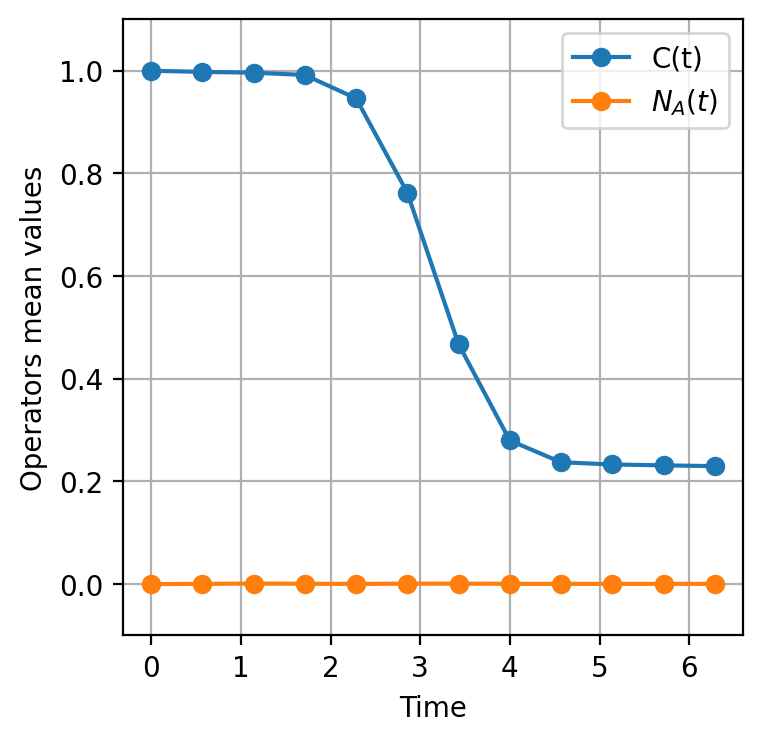

In [22]:
fix, ax = plt.subplots(1, 1, figsize=(4,4), dpi=resol)
ax.plot(times, C_values, marker='o', label='C(t)')
ax.plot(times, N_A_values, marker='o', label='$N_A(t)$')
ax.set_xlabel('Time')
ax.set_ylabel('Operators mean values')
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.grid()

plt.show()


Now create a loop and test for several values of $\omega_0$ with $\omega_A$ fixed

In [23]:
omega_0 = 5
nb_pts = 15
min_detunning, max_detunning = 0, 2
detunning_tab = np.linspace(min_detunning, max_detunning, nb_pts//2)
omega_A_tab = [omega_0 + det for det in detunning_tab] + [omega_0 - det for det in detunning_tab]
omega_A_tab = np.sort(np.unique(np.array(omega_A_tab)))
nb_pts = len(omega_A_tab) #adjust

coherence_tab = []
times_tab = []
N_A_tab = []


g_0 = 3
for i in tqdm(range(nb_pts)):
    omega_A = omega_A_tab[i]
    times, C_values, N_A_values = get_coherence(omega_0, omega_A, g_0, use_WW_approx=True)
    coherence_tab.append(C_values)
    times_tab.append(times)
    N_A_tab.append(N_A_values)

  0%|          | 0/13 [00:00<?, ?it/s]

18.2%. Run time:   0.67s. Est. time left: 00:00:00:03
27.3%. Run time:   1.04s. Est. time left: 00:00:00:02
36.4%. Run time:   1.37s. Est. time left: 00:00:00:02
45.5%. Run time:   1.72s. Est. time left: 00:00:00:02
54.5%. Run time:   2.08s. Est. time left: 00:00:00:01
63.6%. Run time:   2.44s. Est. time left: 00:00:00:01
72.7%. Run time:   2.79s. Est. time left: 00:00:00:01
81.8%. Run time:   3.14s. Est. time left: 00:00:00:00
90.9%. Run time:   3.49s. Est. time left: 00:00:00:00
100.0%. Run time:   3.86s. Est. time left: 00:00:00:00
Total run time:   3.87s
18.2%. Run time:   0.69s. Est. time left: 00:00:00:03
27.3%. Run time:   1.07s. Est. time left: 00:00:00:02
36.4%. Run time:   1.44s. Est. time left: 00:00:00:02
45.5%. Run time:   1.81s. Est. time left: 00:00:00:02
54.5%. Run time:   2.16s. Est. time left: 00:00:00:01
63.6%. Run time:   2.51s. Est. time left: 00:00:00:01
72.7%. Run time:   2.87s. Est. time left: 00:00:00:01
81.8%. Run time:   3.23s. Est. time left: 00:00:00:00
90.

Treat the results

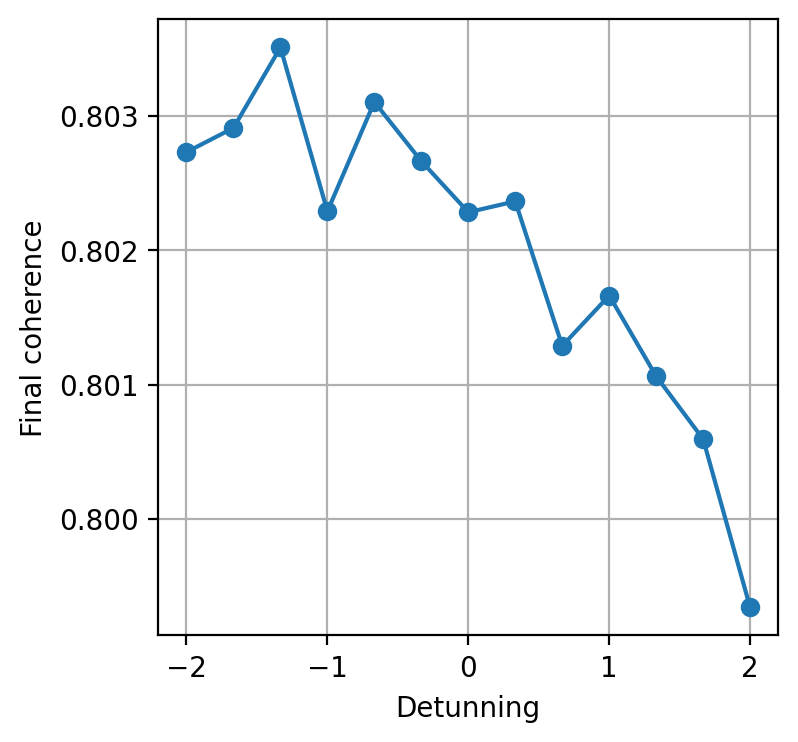

In [24]:
delta_tab = omega_0 - omega_A_tab
final_coherence = np.array([C[-1] for C in coherence_tab])

fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=resol)
ax.plot(delta_tab, final_coherence, marker='o')
ax.set_xlabel('Detunning')
ax.set_ylabel('Final coherence')
ax.grid()

plt.show()
